# Functional Map of the World Country Predictor

### Imports

First we'll ensure this environment matches the requirements

In [1]:
from IPython.display import Image
from PIL import Image as PImage
from os import listdir, path, environ
from uuid import uuid4
from datetime import datetime
import pytz
import pandas as pd
from torch import unsqueeze, no_grad
from torch.nn.functional import softmax
from random import randint

# arthur imports
from arthurai import ArthurAI
from arthurai.common.constants import InputType, OutputType, Stage, ValueType, Enrichment

# project imports
from fmow_model.data import print_dir_counts, random_fname, load_and_preprocess_image, preprocess, \
                 ImageFilesDataset, CATEGORIES, COUNTRY_CODES
from fmow_model.model import new_model, load_model, save_model
from util import create_batch_df, predict_onto_df

### Download the Data

In [2]:
import boto3, tempfile, zipfile
from botocore import UNSIGNED
from botocore.client import Config

s3_client = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
with tempfile.TemporaryDirectory() as tempdir:
    target_path = path.join(tempdir, "data.zip")
    s3_client.Object("s3-bucket-arthur-public", "fmow/fmow-data.zip").download_file(target_path)
    with zipfile.ZipFile(target_path, 'r') as zf:
        zf.extractall()

## The Data

We'll be using [data](https://github.com/fMoW/dataset) from the Functional Map of the World (fMoW) [challenge](https://www.iarpa.gov/challenges/fmow.html), preprocessed by Standford's [WILDS](https://wilds.stanford.edu/datasets/#fmow).

This data consists of satellite images, and the primary challenge is to classify facility, building, and land use from satellite imagery. We'll be using a subset of the data for three of the categories from two countries:

In [3]:
print(f"categories: {', '.join(CATEGORIES)}")
print(f"countries: {', '.join(COUNTRY_CODES)}\n")

categories: amusement_park, place_of_worship, recreational_facility
countries: FRA, RUS



In [4]:
print_dir_counts("fmow-data")

fmow-data/
  recreational_facility/
    test/
      FRA/                    [960 files]
      RUS/                    [242 files]
    train/
      FRA/                    [2240 files]
      RUS/                    [564 files]
  amusement_park/
    test/
      FRA/                    [151 files]
      RUS/                    [433 files]
    train/
      FRA/                    [351 files]
      RUS/                    [1008 files]
  place_of_worship/
    test/
      FRA/                    [186 files]
      RUS/                    [250 files]
    train/
      FRA/                    [434 files]
      RUS/                    [583 files]


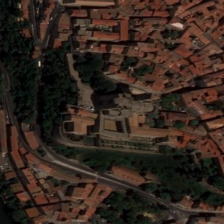

In [5]:
Image(random_fname('place_of_worship'))

## The Model

Rather than predicting which structure is shown in the image, our classifier model will be using [SqueezeNet](https://arxiv.org/abs/1602.07360) to predict which country the image is from.

The model is trained _only_ on pictures of amusement parks. When the model is asked to classify which country images came from, it performs well on images of amusment parks but we'll see performance materially degrade for images of other structures.

In [6]:
model = load_model('fmow_model/fmow-fra-rus.tmsd')
model._get_name()

'SqueezeNet'

In [7]:
# predicting a random image: first element is France, second is Russia

img = PImage.open(random_fname('amusement_park'))
tensor = preprocess(img)
batched = unsqueeze(tensor, dim=0)
with no_grad():
    print(f"prediction: {softmax(model(batched)).numpy()[0]}")

prediction: [0.68502635 0.3149736 ]


[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


In [8]:
train_dir = "fmow-data/amusement_park/train"
test_dir = "fmow-data/amusement_park/test"

df = pd.DataFrame({'satellite_image': [path.join(train_dir, "FRA", x)
                                           for x in listdir(path.join(train_dir, "FRA"))] +
                                          [path.join(train_dir, "RUS", x)
                                           for x in listdir(path.join(train_dir, "RUS"))]})
predict_onto_df(df, model)
df['country'] = df.apply(lambda x: 'france' if "FRA" in x['satellite_image'] else 'russia', axis=1) 
df['feature'] = "amusement_park"
df

,satellite_image,russia,country,feature
0,fmow-data/amusement_park/train/FRA/rgb_img_432...,0.544284,france,amusement_park
1,fmow-data/amusement_park/train/FRA/rgb_img_432...,0.120464,france,amusement_park
2,fmow-data/amusement_park/train/FRA/rgb_img_125...,0.896554,france,amusement_park
3,fmow-data/amusement_park/train/FRA/rgb_img_379...,0.400479,france,amusement_park
4,fmow-data/amusement_park/train/FRA/rgb_img_126...,0.093965,france,amusement_park
...,...,...,...,...
1354,fmow-data/amusement_park/train/RUS/rgb_img_126...,0.940673,russia,amusement_park
1355,fmow-data/amusement_park/train/RUS/rgb_img_128...,0.869105,russia,amusement_park
1356,fmow-data/amusement_park/train/RUS/rgb_img_130...,0.988033,russia,amusement_park
1357,fmow-data/amusement_park/train/RUS/rgb_img_379...,0.861541,russia,amusement_park


## Arthur

### Creating an Arthur Connection

In [43]:
# our connection will read from the ARTHUR_ENDPOINT_URL and ARTHUR_API_KEY environment variables
# you can specify these here if they're you're running this notebook outside of Arthur's environment,
# or pass the values directly into the 'url' and 'access_key' parameters in the connection creation below

# environ['ARTHUR_ENDPOINT_URL'] = "https://app.arthur.ai"
# environ['ARTHUR_API_KEY'] = "<YOUR API KEY>"

In [ ]:
connection = ArthurAI()

### Defining Model

First we'll register the model with Arthur, supplying metadata about the type of inputs the model expects and outputs it will produce.

The DataFrame printed below will show these attributes: an image input attribute, a prediction attribute for France and for Russia, and ground truth attributes for the correct country label

In [10]:
arthur_model = connection.model(partner_model_id=f"FMoW_CountryPredictor_FG-{datetime.now().strftime('%Y%m%d%H%M%S')}",
                                display_name="FMoW Country Predictor",
                                input_type=InputType.Image,
                                output_type=OutputType.Multiclass,
                                pixel_height=224,
                                pixel_width=224,
                                is_batch=True)


We'll use this dataframe as the reference set for Arthur to use for evaluating drift. Arthur will quantify the similary of future images to the reference set. If the inferences that our model receives down the road are different than the ones it trained on, it may be a sign that the model is getting stale and needs to be retrained. 

Since there is no intuitive positive class for this example, we have randomly chosen Russia to act as the positive predicted attribute. This does nothing to change our binary classification, instead it only indicates some things that we will have to do going forward (i.e. when making predictions predict Russia). We could have also done this as a multi-class classification problem, which you can find in other examples like our NLP Medical Transcript Classifier.

In [11]:
# our predicted columns "france" and "russia" correspond to the string values "france" and "russia" in the ground truth column "country" respectively
output_mapping = {
    "france" : "france",
    "russia": "russia"
}

arthur_model.build(df,
                   non_input_columns=['feature'],
                   ground_truth_column="country",
                   pred_to_ground_truth_map= output_mapping,
                   positive_predicted_attr = 'russia')

2022-07-25 13:36:49,558 - arthurai.core.models - WARNING - Found one or more categorical attributes. It is suggested to use model.review() to verify all possible categories were inferred correctly for each categorical attribute. To update with new categories, use model.get_attribute(attr_name).set(categories=[cat_1, cat_2, cat_3])
2022-07-25 13:36:49,559 - arthurai.core.models - INFO - Please review the inferred schema. If everything looks correct, lock in your model by calling arthur_model.save()


,name,stage,value_type,categorical,is_unique,categories,bins,range,monitor_for_bias
0,satellite_image,PIPELINE_INPUT,IMAGE,False,True,[],None,"[None, None]",False
1,feature,NON_INPUT_DATA,STRING,True,False,[{value: amusement_park}],None,"[None, None]",False
2,country,GROUND_TRUTH_CLASS,STRING,True,False,"[{value: russia}, {value: france}]",None,"[None, None]",False
3,france,PREDICTED_VALUE,FLOAT,False,False,[],None,"[0, 1]",False
4,russia,PREDICTED_VALUE,FLOAT,False,False,[],None,"[0, 1]",False


In [12]:
# adding other categories that will serve as anomalous later
arthur_model.get_attribute(name="feature").set(categories=['amusement_park', 
                                                           'place_of_worship', 
                                                           'recreational_facility'])

ArthurAttribute(name='feature', value_type='STRING', stage='NON_INPUT_DATA', id=None, label=None, position=0, categorical=True, min_range=None, max_range=None, monitor_for_bias=False, categories=[AttributeCategory(value='amusement_park', label=None), AttributeCategory(value='place_of_worship', label=None), AttributeCategory(value='recreational_facility', label=None)], bins=None, is_unique=False, is_positive_predicted_attribute=False, attribute_link=None, gt_class_link=None)

In [13]:
arthur_model.review()

,name,stage,value_type,categorical,is_unique,categories,bins,range,monitor_for_bias
0,satellite_image,PIPELINE_INPUT,IMAGE,False,True,[],None,"[None, None]",False
1,feature,NON_INPUT_DATA,STRING,True,False,"[{value: amusement_park}, {value: place_of_wor...",None,"[None, None]",False
2,country,GROUND_TRUTH_CLASS,STRING,True,False,"[{value: russia}, {value: france}]",None,"[None, None]",False
3,france,PREDICTED_VALUE,FLOAT,False,False,[],None,"[0, 1]",False
4,russia,PREDICTED_VALUE,FLOAT,False,False,[],None,"[0, 1]",False


If the above looks good, we'll call save to register the model with Arthur and retrieve a Model ID.

In [14]:
model_id = arthur_model.save()
with open("fullguide_model_id.txt", "w") as f:
    f.write(model_id)

2022-07-25 13:36:50,482 - arthurai.core.models - INFO - Processing image data, this may take a couple minutes
2022-07-25 13:36:55,699 - arthurai.core.models - INFO - Image processing complete!
2022-07-25 13:36:55,701 - arthurai.core.data_service - INFO - Starting upload (138.217 MB in 1 files), depending on data size this may take a few minutes
2022-07-25 13:37:31,982 - arthurai.core.data_service - INFO - Upload completed: /var/folders/g9/hcpwvt1n62g70yggw4n6kn_w0000gn/T/tmptdc5d3mf/b89c04ea-cb5c-4581-8947-ec163d7d1e37.parquet


In [15]:
# you can fetch a model by ID. for example pull the last-created model:
# with open("fullguide_model_id.txt", "r") as f:
#     model_id = f.read()
# arthur_model = connection.get_model(model_id)

### Enabling Explainability

In [16]:
import os
project_dir = os.path.join(os.getcwd(), "fmow_model")

arthur_model.enable_explainability(
    project_directory=project_dir,
    user_predict_function_import_path='entrypoint',
    streaming_explainability_enabled=True,
    explanation_algo='lime',
    explanation_nsamples=2000
)

Ignoring folder: /Users/haleymassa/Documents/Arthur Git Work/arthur-sandbox/examples/example_projects/cv_satellite_country_prediction/fmow_model
Ignoring folder: /Users/haleymassa/Documents/Arthur Git Work/arthur-sandbox/examples/example_projects/cv_satellite_country_prediction/fmow_model/__pycache__


'ok'

### Sending Batches

Next we'll randomly sample our test data, making predictions and sending them to Arthur.

In [17]:
def send_df_batch(df, batch_id):
    inferences = []
    for _, row in df.iterrows():
        inf = {'satellite_image': row['satellite_image'],
               'russia': row['russia'],
               'feature': row['feature'],
               'country': row['country']}
        inferences.append(inf)
    return arthur_model.send_inferences(inferences, batch_id=batch_id)

In [18]:
def create_and_send_batch(category):
    print(f"generating and sending batch for {category}")
    df = create_batch_df(category)
    predict_onto_df(df, model)
    batch_id = category + "-" + str(uuid4()).split("-")[1]
    return send_df_batch(df, batch_id)

We can expect that the model will perform well and have low drift or the batches pulled from the Amusement Park subset.

But as the model is asked to classify Places of Worship and Recreational Facilities it won't perform as well, and we can expect those batches to have higher drift as well.

In [19]:
create_and_send_batch("amusement_park")
create_and_send_batch("amusement_park")
create_and_send_batch("amusement_park")
create_and_send_batch("place_of_worship")
create_and_send_batch("amusement_park")
create_and_send_batch("recreational_facility")
create_and_send_batch("amusement_park")
create_and_send_batch("place_of_worship")
create_and_send_batch("amusement_park")
create_and_send_batch("recreational_facility")

generating and sending batch for amusement_park


2022-07-25 13:37:36,216 - arthurai.core.models - INFO - 80 rows were missing inference_timestamp fields, so the current time was populated
2022-07-25 13:37:36,216 - arthurai.core.models - INFO - 80 rows were missing ground_truth_timestamp fields, so the current time was populated
2022-07-25 13:37:36,216 - arthurai.core.models - INFO - 80 rows were missing partner_inference_id fields, so UUIDs were generated, see return values


generating and sending batch for amusement_park


2022-07-25 13:37:40,389 - arthurai.core.models - INFO - 51 rows were missing inference_timestamp fields, so the current time was populated
2022-07-25 13:37:40,389 - arthurai.core.models - INFO - 51 rows were missing ground_truth_timestamp fields, so the current time was populated
2022-07-25 13:37:40,390 - arthurai.core.models - INFO - 51 rows were missing partner_inference_id fields, so UUIDs were generated, see return values


generating and sending batch for amusement_park


2022-07-25 13:37:43,347 - arthurai.core.models - INFO - 38 rows were missing inference_timestamp fields, so the current time was populated
2022-07-25 13:37:43,348 - arthurai.core.models - INFO - 38 rows were missing ground_truth_timestamp fields, so the current time was populated
2022-07-25 13:37:43,349 - arthurai.core.models - INFO - 38 rows were missing partner_inference_id fields, so UUIDs were generated, see return values


generating and sending batch for place_of_worship


2022-07-25 13:37:45,899 - arthurai.core.models - INFO - 36 rows were missing inference_timestamp fields, so the current time was populated
2022-07-25 13:37:45,900 - arthurai.core.models - INFO - 36 rows were missing ground_truth_timestamp fields, so the current time was populated
2022-07-25 13:37:45,900 - arthurai.core.models - INFO - 36 rows were missing partner_inference_id fields, so UUIDs were generated, see return values


generating and sending batch for amusement_park


2022-07-25 13:37:49,520 - arthurai.core.models - INFO - 65 rows were missing inference_timestamp fields, so the current time was populated
2022-07-25 13:37:49,520 - arthurai.core.models - INFO - 65 rows were missing ground_truth_timestamp fields, so the current time was populated
2022-07-25 13:37:49,521 - arthurai.core.models - INFO - 65 rows were missing partner_inference_id fields, so UUIDs were generated, see return values


generating and sending batch for recreational_facility


2022-07-25 13:37:53,186 - arthurai.core.models - INFO - 44 rows were missing inference_timestamp fields, so the current time was populated
2022-07-25 13:37:53,187 - arthurai.core.models - INFO - 44 rows were missing ground_truth_timestamp fields, so the current time was populated
2022-07-25 13:37:53,187 - arthurai.core.models - INFO - 44 rows were missing partner_inference_id fields, so UUIDs were generated, see return values


generating and sending batch for amusement_park


2022-07-25 13:37:57,049 - arthurai.core.models - INFO - 78 rows were missing inference_timestamp fields, so the current time was populated
2022-07-25 13:37:57,050 - arthurai.core.models - INFO - 78 rows were missing ground_truth_timestamp fields, so the current time was populated
2022-07-25 13:37:57,050 - arthurai.core.models - INFO - 78 rows were missing partner_inference_id fields, so UUIDs were generated, see return values


generating and sending batch for place_of_worship


2022-07-25 13:38:01,748 - arthurai.core.models - INFO - 62 rows were missing inference_timestamp fields, so the current time was populated
2022-07-25 13:38:01,749 - arthurai.core.models - INFO - 62 rows were missing ground_truth_timestamp fields, so the current time was populated
2022-07-25 13:38:01,749 - arthurai.core.models - INFO - 62 rows were missing partner_inference_id fields, so UUIDs were generated, see return values


generating and sending batch for amusement_park


2022-07-25 13:38:06,847 - arthurai.core.models - INFO - 93 rows were missing inference_timestamp fields, so the current time was populated
2022-07-25 13:38:06,847 - arthurai.core.models - INFO - 93 rows were missing ground_truth_timestamp fields, so the current time was populated
2022-07-25 13:38:06,847 - arthurai.core.models - INFO - 93 rows were missing partner_inference_id fields, so UUIDs were generated, see return values


generating and sending batch for recreational_facility


2022-07-25 13:38:11,939 - arthurai.core.models - INFO - 92 rows were missing inference_timestamp fields, so the current time was populated
2022-07-25 13:38:11,940 - arthurai.core.models - INFO - 92 rows were missing ground_truth_timestamp fields, so the current time was populated
2022-07-25 13:38:11,940 - arthurai.core.models - INFO - 92 rows were missing partner_inference_id fields, so UUIDs were generated, see return values


{'counts': {'failure': 0, 'success': 92, 'total': 92}, 'failures': []}